# Save yaml files for SIMCEO drivers

- TT7 Controller
- FSM Controller
- AZ, EL, and GIR Controller
- M2 Positiones (ad hoc) dynamic model and SS representation to merge M2 RBM from the FEM and the positioner
- State-space (SS) model to merge active optics bending mode corrections and the M1 support actuator forces

In [13]:
import numpy as np
import scipy.io as spio
#import scipy.linalg as la
from scipy import signal

import os
from os import path

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

### Load IMS data file with controllers and interface parameters

In [67]:
# The files with controller and interface models are available from the GMT-IMS repository
filepath = '/Users/rromano/Workspace/GMT-IMS/'
# filename = os.path.join(filepath,'controls_5pt1a_OAD.mat')
filename = os.path.join(filepath,'controls_5pt1a_dev.mat')

### Fast tip-tilt (TT) controller file (with PZT_cmd decoupled outputs)

In [68]:
# PZT commands decoupling matrix
tt2pzt = spio.loadmat(filename)['tt7']['TT2PZT'][0][0]
# TT feedback controller (SS) model
tt7_fbC = spio.loadmat(filename)['tt7']['FBc_ss'][0][0][0][0]

print('Controller dimensions:',
      '\nA:',tt7_fbC['A'].shape,
      '\nB:',tt7_fbC['B'].shape,
      '\nC:',tt7_fbC['C'].shape,
      '\nD:',tt7_fbC['D'].shape)

Controller dimensions: 
A: (56, 56) 
B: (56, 14) 
C: (14, 56) 
D: (14, 14)


In [69]:
tt7Dec_ctrl_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': tt7_fbC['A'].tolist(),
                               'B': (-tt7_fbC['B']).tolist(),
                               'C': (tt2pzt@tt7_fbC['C']).tolist(),
                               'D': (-tt2pzt@tt7_fbC['D']).tolist()}
               }}

if filename[-7:] == 'dev.mat':
    tt_yaml_file = 'TTDec_control_dev.yaml'
else:
    tt_yaml_file = 'TTDec_control_OAD.yaml'

if True:
    # Save fast TT controller yaml file
    with open(tt_yaml_file,'w') as f:
        y.dump(tt7Dec_ctrl_dt, f)
    print('TT controller file saved as %s ' %tt_yaml_file)    
#    # Save fast TT controller pickle file
#    with open('TTDec_control.pickle','wb') as f:
#        pickle.dump(tt7Dec_ctrl_dt,f)    

TT controller file saved as TTDec_control_dev.yaml 


### M2 FSM feedback controller

In [70]:
fsm_fbC = spio.loadmat(filename)['mimo_fsmC'][0][0]
print('Controller dimensions:',
      '\nA:',fsm_fbC['A'].shape,
      '\nB:',fsm_fbC['B'].shape,
      '\nC:',fsm_fbC['C'].shape,
      '\nD:',fsm_fbC['D'].shape)

Controller dimensions: 
A: (168, 168) 
B: (168, 21) 
C: (21, 168) 
D: (21, 21)


In [71]:
# Mapping from [r;y] to e (error signal)
Me = np.hstack((np.kron(np.eye(7), np.eye(3)),
                np.kron(np.eye(7), np.hstack((np.eye(3),
                                              -np.eye(3))))))
# Matrix to dristribute the PZT forces (mirror and cell sides)
Mu = np.kron(np.eye(7), np.vstack((-np.eye(3), np.eye(3))))

fsm_ctrl_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': fsm_fbC['A'].tolist(),
                               'B': (fsm_fbC['B'] @ Me).tolist(),
                               'C': (Mu @ fsm_fbC['C']).tolist(),
                               'D': (Mu @ fsm_fbC['D'] @ Me).tolist()}
               }}

if filename[-7:] == 'dev.mat':
    fsm_yaml_file = 'FSM_control_dev.yaml'
else:
    fsm_yaml_file = 'FSM_control_OAD.yaml'

if True:
    # Save fast TT controller yaml file
    with open(fsm_yaml_file,'w') as f:
        y.dump(fsm_ctrl_dt, f)
    print('FSM controller file saved as %s ' %fsm_yaml_file)  

FSM controller file saved as FSM_control_dev.yaml 


### Mount controllers

In [192]:
mount_fbC = spio.loadmat(filename)['mount'][0]
print("Mount Ts:%0.3gs"%mount_fbC[0][0])

# yaml filenames
az_yaml_file = 'AZ_fb_ssC.yaml'
el_yaml_file = 'EL_fb_ssC.yaml'
gir_yaml_file = 'GIR_fb_ssC.yaml'

Mount Ts:0.005s


#### Azimuth controller

In [193]:
az = mount_fbC[0][1][0][0]
az_fbC = az[0][0][0]
drv_radius = az[4]
print("AZ radius:%0.4gs"%drv_radius)
print('Controller dimensions:',
      '\nA:',az_fbC['A'].shape,
      '\nB:',az_fbC['B'].shape,
      '\nC:',az_fbC['C'].shape,
      '\nD:',az_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,4)),-np.ones((1,4))))/4/drv_radius))

az_fbC_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': az_fbC['A'].tolist(),
                               'B': (az_fbC['B'] @ Me).tolist(),
                               'C': az_fbC['C'].tolist(),
                               'D': (az_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast AZ controller yaml file
    with open(az_yaml_file,'w') as f:
        y.dump(az_fbC_dt, f)
    print('Mount AZ controller file saved as %s ' %az_yaml_file)

AZ radius:9.493s
Controller dimensions: 
A: (7, 7) 
B: (7, 1) 
C: (1, 7) 
D: (1, 1)
Azimuth mount controller file saved as AZ_fb_ssC.yaml 


#### Elevation controller

In [194]:
el = mount_fbC[0][2][0][0]
el_fbC = el[0][0][0]
drv_radius = el[4]
print("EL radius:%0.4gs"%drv_radius)
print('Controller dimensions:',
      '\nA:',el_fbC['A'].shape,
      '\nB:',el_fbC['B'].shape,
      '\nC:',el_fbC['C'].shape,
      '\nD:',el_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,4)),-np.ones((1,4))))/4/drv_radius))

el_fbC_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': el_fbC['A'].tolist(),
                               'B': (el_fbC['B'] @ Me).tolist(),
                               'C': el_fbC['C'].tolist(),
                               'D': (el_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast EL controller yaml file
    with open(el_yaml_file,'w') as f:
        y.dump(el_fbC_dt, f)
    print('Mount EL controller file saved as %s ' %el_yaml_file)

EL radius:10.36s
Controller dimensions: 
A: (11, 11) 
B: (11, 1) 
C: (1, 11) 
D: (1, 1)
Mount EL controller file saved as EL_fb_ssC.yaml 


#### GIR controller

In [195]:
gir = mount_fbC[0][3][0][0]
gir_fbC = gir[0][0][0]
print("(!) For now, we not convert from ENC GIR to GIR angular displacement")
print('Controller dimensions:',
      '\nA:',gir_fbC['A'].shape,
      '\nB:',gir_fbC['B'].shape,
      '\nC:',gir_fbC['C'].shape,
      '\nD:',gir_fbC['D'].shape)

# Mapping from [r;Az enc] to e (error signal)
Me = np.hstack((np.atleast_2d(1),np.hstack((np.ones((1,2)),-np.ones((1,2))))/2))

gir_fbC_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': gir_fbC['A'].tolist(),
                               'B': (gir_fbC['B'] @ Me).tolist(),
                               'C': gir_fbC['C'].tolist(),
                               'D': (gir_fbC['D'] @ Me).tolist()}
               }}

if True:
    # Save fast GIR controller yaml file
    with open(gir_yaml_file,'w') as f:
        y.dump(gir_fbC_dt, f)
    print('Mount GIR controller file saved as %s ' %gir_yaml_file)

(!) For now, we not convert from ENC GIR to GIR angular displacement
Controller dimensions: 
A: (6, 6) 
B: (6, 1) 
C: (1, 6) 
D: (1, 1)
Mount GIR controller file saved as GIR_fb_ssC.yaml 


### M2 Positioner (ad hoc) dynamic model

In [6]:
# 2nd order TF parameters
wn = 2*np.pi*2
zeta = 0.7
# CT TF
ctM2PosTF = signal.TransferFunction([wn**2], [1, 2*zeta*wn, wn**2])
M2PosTF = signal.cont2discrete((ctM2PosTF.num,ctM2PosTF.den), dt=0.5e-3, method='foh')
print(M2PosTF[0])

M2Pos_adhoc_DynModel_dt = {'System' :{
    'sampling time': 0.5e-3, 
    'parameters': { 'num': M2PosTF[0][0].tolist(),
                    'denom': M2PosTF[1][:].tolist()}
               }}
m2Pos_yaml_file = 'M2Pos_adhoc_DynModel.yaml'

if False:
    # Save fast GIR controller yaml file
    with open(m2Pos_yaml_file,'w') as f:
        y.dump(M2Pos_adhoc_DynModel_dt, f)
    print('M2 Pos ad hoc TF file saved as %s ' %m2Pos_yaml_file)


[[6.56527914e-06 2.62034151e-05 6.53646693e-06]]
Model file to add M2 RBM from FEM and from the Positioner saved as add_M2_Pos_FEM.yaml 


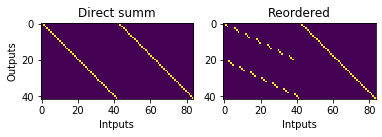


Model file to add M2 RBM from FEM and from the Positioner saved as add_M2_Pos_FEM.yaml 


In [37]:

# Flag to perform M2 RBM reordering (just the first 42 entries are reordered)
reorder_M2RBM = True

# Matrix to summ the inputs
ssD = np.hstack((np.eye(42),np.eye(42)))
if reorder_M2RBM:
    QTxyz = np.kron(np.eye(7), np.hstack((np.eye(3), np.zeros((3,3)))))
    QRxyz = np.kron(np.eye(7), np.hstack((np.zeros((3,3)), np.eye(3))))    
    ssD = np.hstack((np.vstack((QTxyz,QRxyz)).dot(np.eye(42)),np.eye(42)))
    if True:
        plt.subplot(1,2,1)
        plt.imshow(np.hstack((np.eye(42),np.eye(42))))
        plt.ylabel('Outputs'), plt.xlabel('Intputs'), plt.title('Direct summ')
        plt.subplot(1,2,2)
        plt.imshow(ssD), plt.xlabel('Intputs'), plt.title('Reordered')
        plt.show()

add_M2_Pos_FEM_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': np.zeros((1, 1)).tolist(),
                               'B': np.zeros((1, 84)).tolist(),
                               'C': np.zeros((42, 1)).tolist(),
                               'D': ssD.tolist()}
               }}
add_M2_Pos_FEM_file = 'add_M2_Pos_FEM.yaml'

if True:
    # Save SS model file to add M2 RBM from FEM and from the Positioner
    with open(add_M2_Pos_FEM_file,'w') as f:
        y.dump(add_M2_Pos_FEM_dt,f)   
    print('\nModel file to add M2 RBM from FEM and from the Positioner saved as %s ' %add_M2_Pos_FEM_file)

### State-space model to add the AcO BM corrections into the SA forces

In [2]:
filepath = '/Users/rromano/Workspace/GMTDatafiles/20200319 Rodrigo k6rot 100000 c/'
filename = os.path.join(filepath,'m1BM2F.mat')
m1BM2F = spio.loadmat(filename)['m1BM2F']

n_u1, n_u2 = m1BM2F.shape[0], m1BM2F.shape[1]

add_AcO_F_dt = {'System' :
               {'sampling time': 0.5e-3, #second ,
                'parameters': {'A': np.zeros((1, 1)).tolist(),
                               'B': np.zeros((1, n_u1+n_u2)).tolist(),
                               'C': np.zeros((n_u1, 1)).tolist(),
                               'D': np.hstack((np.eye(n_u1),m1BM2F)).tolist()}
               }}
add_AcO_F_file = 'add_AcO_F.pickle'

if True:
    # Save SS model file to add the AcO BM corrections into the SA forces
    with open(add_AcO_F_file,'wb') as f:
        pickle.dump(add_AcO_F_dt,f)   
    print('Model file to add the AcO BM corrections into the SA forces saved as %s ' %add_AcO_F_file)


Model file to add the AcO BM corrections into the SA forces saved as add_AcO_F.pickle 
